# Heterogeneous Construction

In [1]:
%load_ext autoreload
%autoreload 2

# System imports
import sys
import yaml
import logging
import os

# External imports
import matplotlib.pyplot as plt
import numpy as np

# import seaborn as sns
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import  WandbLogger
from tqdm import tqdm

import warnings
logging.basicConfig(level=logging.INFO)

warnings.filterwarnings("ignore")
sys.path.append("../../..")
device = "cuda" if torch.cuda.is_available() else "cpu"

from hetero_utils import build_hetero_graphs
from LightningModules.Filter.Models.vanilla_filter import VanillaFilter
from LightningModules.Filter.Models.pyramid_filter import PyramidFilter
from LightningModules.Filter.Models.hetero_pyramid import HeteroPyramidFilter
from LightningModules.GNN.Models.hetero_gnn import HeteroGNN

## Setup

In [4]:
with open("hetero_filter.yaml") as f:
    hparams = yaml.load(f, Loader=yaml.FullLoader)

In [5]:
model = HeteroPyramidFilter(hparams)

## Build New HeteroGraphs

In [3]:
base_dir = "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/embedding_processed/0GeV_uncorrelated_large"
new_save_path = "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/hetero_embedding_processed/0GeV_uncorrelated_large"
build_hetero_graphs(base_dir, new_save_path, max_events=2000, use_process_map=True)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

## Dataset Validation

First, let's look at the distribution of true and fake in each volume ID

In [47]:
model.setup(stage="fit")

In [48]:
sample = model.trainset[0]

In [49]:
sample

Data(x=[342088, 9], cell_data=[342088, 11], pid=[342088], event_file='/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000016278', hid=[342088], pt=[342088], primary=[342088], nhits=[342088], modules=[342088], modulewise_true_edges=[2, 137265], signal_true_edges=[2, 15674], edge_index=[2, 121278], y=[121278], volume_id=[342088], y_pid=[121278])

In [50]:
true = sample.edge_index[:, sample.y]
fake = sample.edge_index[:, ~sample.y]

In [51]:
true_vol_id = sample.volume_id[true]
fake_vol_id = sample.volume_id[fake]

In [10]:
vol_lookup = torch.tensor([[0, 1, 2, 3], [1, 4, 5, 6], [2, 5, 7, 8], [3, 6, 8, 9]])

In [11]:
true_edge_volume = vol_lookup[true_vol_id[0], true_vol_id[1]]
fake_edge_volume = vol_lookup[fake_vol_id[0], fake_vol_id[1]]

In [28]:
# Get random selection of fake edge volumes
fake_edge_volume = fake_edge_volume[torch.randperm(fake_edge_volume.shape[0])]

In [29]:
fake_edge_volume = fake_edge_volume[:true_edge_volume.shape[0]*10]

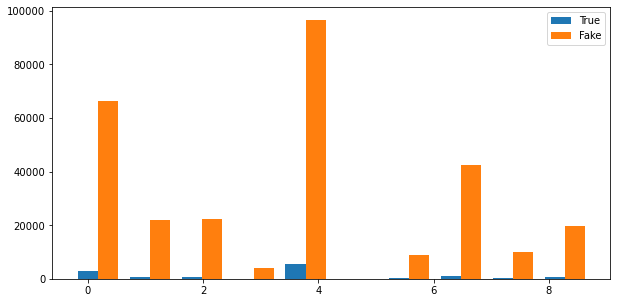

In [12]:
# Make histogram of edge volume by fake and true
true_hist, true_bins = np.histogram(true_edge_volume, bins=10)
fake_hist, fake_bins = np.histogram(fake_edge_volume, bins=10)
# Make bar chart of true_hist and fake_hist side by side
width = 0.35
fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(true_bins[:-1], true_hist, width, label="True")
plt.bar(fake_bins[:-1] + width, fake_hist, width, label="Fake")
plt.legend()
plt.show()

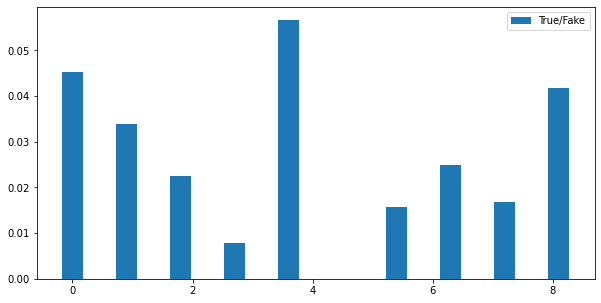

In [13]:
# Make histogram of edge volume by fake and true
true_hist, true_bins = np.histogram(true_edge_volume, bins=10)
fake_hist, fake_bins = np.histogram(fake_edge_volume, bins=10)
# Make bar chart of true_hist / fake_hist
width = 0.35
fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(true_bins[:-1], true_hist / fake_hist, width, label="True/Fake")
plt.legend()

### Dynamic Combos

In [125]:
vol_list = [[0, 1, 2], [3]]

In [126]:
vol_list

[[0, 1, 2], [3]]

In [127]:
combos = torch.tensor([[0,0], [0, 1], [1,1]])

In [128]:
combos

tensor([[0, 0],
        [0, 1],
        [1, 1]])

In [129]:
labels = torch.tensor([0, 1, 2])

In [130]:
labels

tensor([0, 1, 2])

In [131]:
all_vol_ids = torch.empty(4, 4)

In [132]:
all_vol_ids

tensor([[ 4.2389e-06,  4.5584e-41, -1.4209e-02,  3.0872e-41],
        [ 0.0000e+00,  1.8750e+00,  0.0000e+00,  1.8750e+00],
        [ 0.0000e+00,  1.8750e+00,  0.0000e+00,  1.8750e+00],
        [ 0.0000e+00,  4.7684e-06,  0.0000e+00,  1.8750e+00]])

In [134]:
all_vol_ids = torch.empty(4, 4)
for i, combo in enumerate(combos):
    print(combo)
    stacked_combo = torch.stack(torch.meshgrid(torch.tensor(vol_list[combo[0]]), torch.tensor(vol_list[combo[1]])), dim=-1).flatten(0,1).T
    stacked_combo = torch.cat([stacked_combo, stacked_combo.flip(0)], dim=-1)
    print(stacked_combo)
    all_vol_ids[stacked_combo[0], stacked_combo[1]] = i
    print(all_vol_ids)

tensor([0, 0])
tensor([[0, 0, 0, 1, 1, 1, 2, 2, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2],
        [0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 0, 0, 1, 1, 1, 2, 2, 2]])
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0871e-41],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([0, 1])
tensor([[0, 1, 2, 3, 3, 3],
        [3, 3, 3, 0, 1, 2]])
tensor([[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 1., 1., 0.]])
tensor([1, 1])
tensor([[3, 3],
        [3, 3]])
tensor([[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 1., 1., 2.]])


In [118]:
stacked_combo = torch.stack(torch.meshgrid(vol_list[combo][0], vol_list[combo][1]), dim=-1).flatten(0,1).T

In [120]:
stacked_combo = torch.cat([stacked_combo, stacked_combo.flip(0)], dim=-1)

In [121]:
stacked_combo

tensor([[2, 2, 3, 3, 2, 3, 2, 3],
        [2, 3, 2, 3, 2, 2, 3, 3]])

In [114]:
stacked_combo.flatten(0, 1)

tensor([[2, 2],
        [2, 3],
        [3, 2],
        [3, 3]])

In [85]:
combo

tensor([1, 1])

In [86]:
vol_list[combo][0], vol_list[combo][1]

(tensor([2, 3]), tensor([2, 3]))

In [103]:
stacked_combo = torch.stack(torch.meshgrid(vol_list[combo][0], vol_list[combo][1]), dim=-1)

In [108]:
all_vol_ids[stacked_combo[0], stacked_combo[1]]

tensor([[0., 0.],
        [0., 0.]])

## Train Filter

In [7]:
logger = WandbLogger(
    project=hparams["project"], group="Balanced", save_dir=hparams["artifacts"]
)
trainer = Trainer(
    gpus=1, max_epochs=hparams["max_epochs"], logger=logger
)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params
---------------------------------------------
0 | edge_encoders | ModuleList | 7.2 M 
---------------------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.754    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Performance Validation

### Roadmap

1. Make model loading function
2. Make robust inference function
3. Make well-partitioned eta & pt performance functions
4. Make performance plotting function

In [25]:
from gnn_utils import run_eta_performance, run_pt_performance

### Build Pre-constructed performance evaluation function

In [12]:
model.setup(stage='fit')

In [ ]:
def run_eta_performance(checkpoint_path, model_type, dataset_type, num_events, score_cut, common_axes = None, vmin=[None, None, None], vmax=[None, None, None]):
    model, _ = load_model(checkpoint_path, model_type)
    results = inference(model, dataset_type, num_events)
    get_topline_stats(results, score_cut)
    av_eta_pred, av_eta_signal_true, av_eta_signal_true_pos, av_eta_bkg_true_pos, av_r_pred, av_r_signal_true, av_r_signal_true_pos, av_r_bkg_true_pos = build_edge_eta_list(results)
    eff_ax, signal_pur_ax, bkg_pur_ax = plot_metrics(av_eta_pred, av_eta_signal_true, av_eta_signal_true_pos, av_eta_bkg_true_pos, common_axes = common_axes)
    if common_axes is None:
        plot_eta_r_metrics(av_eta_pred, av_eta_signal_true, av_eta_signal_true_pos, av_eta_bkg_true_pos, av_r_pred, av_r_signal_true, av_r_signal_true_pos, av_r_bkg_true_pos, vmin=vmin, vmax=vmax)

    return eff_ax, signal_pur_ax, bkg_pur_ax

In [ ]:
model.valset[0]

Data(x=[295698, 9], cell_data=[295698, 11], pid=[295698], event_file='/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010912', hid=[295698], pt=[295698], primary=[295698], nhits=[295698], modules=[295698], modulewise_true_edges=[2, 117468], signal_true_edges=[2, 15501], edge_index=[2, 581597], y=[581597], y_pid=[581597], volume_id=[295698], pid_signal=[581597])

In [17]:
def build_construction_eta_list(model, dataset_type, num_events):
    assert dataset_type in ["train", "val", "test"] , "dataset type must be one of ['train', 'val', 'test']"

    # Get dataset
    dataset_name = f"{dataset_type}set"

    trainsplit_dict = {"train": 0, "val": 1, "test": 2}
    model.hparams["datatype_split"] = [1, 1, 1]
    model.hparams["datatype_split"][trainsplit_dict[dataset_type]] = num_events
    model.setup(stage="fit")
    dataset = getattr(model, dataset_name)

    av_eta_pred, av_eta_signal_true, av_eta_signal_true_pos, av_eta_bkg_true_pos = [], [], [], []
    av_r_pred, av_r_signal_true, av_r_signal_true_pos, av_r_bkg_true_pos = [], [], [], []

    for result in tqdm(dataset):

        edge_pos = result.edge_index
        edge_signal_true = result.signal_true_edges
        edge_signal_true_pos = result.edge_index[:, result.y]
        edge_bkg_true_pos = result.edge_index[:, result.y_pid]

        eta_hits = calc_eta(result.x[:, 0], result.x[:, 2])
        av_eta_pred.append((eta_hits[edge_pos[0]] + eta_hits[edge_pos[1]]) / 2)
        av_eta_signal_true.append((eta_hits[edge_signal_true[0]] + eta_hits[edge_signal_true[1]]) / 2)
        av_eta_signal_true_pos.append((eta_hits[edge_signal_true_pos[0]] + eta_hits[edge_signal_true_pos[1]]) / 2)
        av_eta_bkg_true_pos.append((eta_hits[edge_bkg_true_pos[0]] + eta_hits[edge_bkg_true_pos[1]]) / 2)

        r_hits = result.x[:, 0]
        av_r_pred.append((r_hits[edge_pos[0]] + r_hits[edge_pos[1]]) / 2)
        av_r_signal_true.append((r_hits[edge_signal_true[0]] + r_hits[edge_signal_true[1]]) / 2)
        av_r_signal_true_pos.append((r_hits[edge_signal_true_pos[0]] + r_hits[edge_signal_true_pos[1]]) / 2)
        av_r_bkg_true_pos.append((r_hits[edge_bkg_true_pos[0]] + r_hits[edge_bkg_true_pos[1]]) / 2)


    # Concatenate all lists of tensors
    av_eta_pred = torch.cat(av_eta_pred)
    av_eta_signal_true = torch.cat(av_eta_signal_true)
    av_eta_signal_true_pos = torch.cat(av_eta_signal_true_pos)
    av_eta_bkg_true_pos = torch.cat(av_eta_bkg_true_pos)

    av_r_pred = torch.cat(av_r_pred)
    av_r_signal_true = torch.cat(av_r_signal_true)
    av_r_signal_true_pos = torch.cat(av_r_signal_true_pos)
    av_r_bkg_true_pos = torch.cat(av_r_bkg_true_pos)
    

    return av_eta_pred, av_eta_signal_true, av_eta_signal_true_pos, av_eta_bkg_true_pos, av_r_pred, av_r_signal_true, av_r_signal_true_pos, av_r_bkg_true_pos

In [22]:
av_eta_pred, av_eta_signal_true, av_eta_signal_true_pos, av_eta_bkg_true_pos, av_r_pred, av_r_signal_true, av_r_signal_true_pos, av_r_bkg_true_pos = build_construction_eta_list(model, "val", 100)

100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


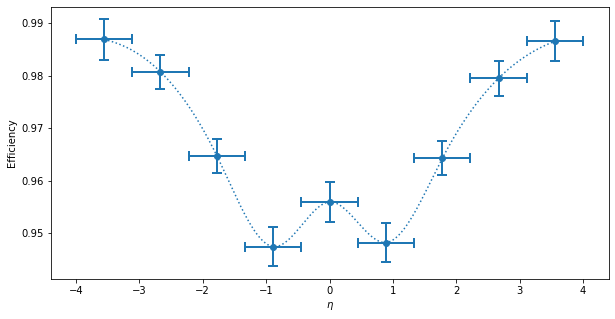

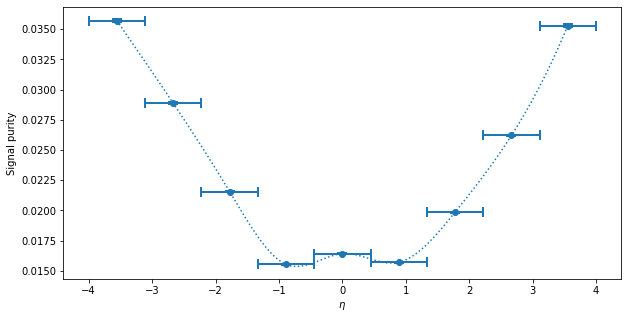

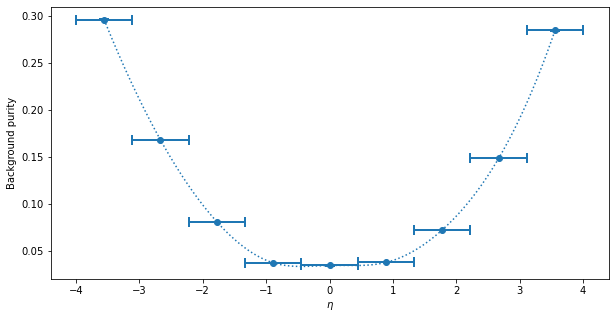

In [23]:
eff_ax, signal_pur_ax, bkg_pur_ax = plot_metrics(av_eta_pred, av_eta_signal_true, av_eta_signal_true_pos, av_eta_bkg_true_pos)

In [19]:
from gnn_utils import calc_eta, plot_metrics, plot_eta_r_metrics

### Full Detector Filter Performance

Single model across whole detector:

100%|██████████| 10/10 [00:00<00:00, 33.93it/s]


Signal efficiency: tensor(0.9803) Signal purity: tensor(0.0236) Background purity: tensor(0.1128)


100%|██████████| 10/10 [00:00<00:00, 17.71it/s]


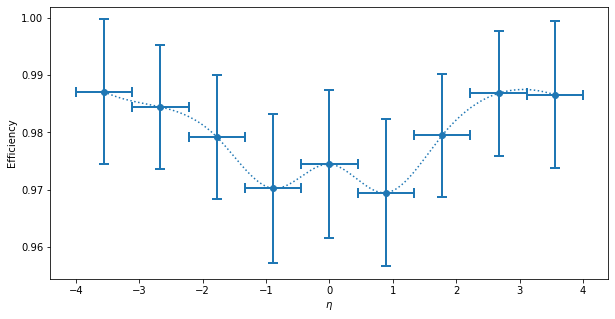

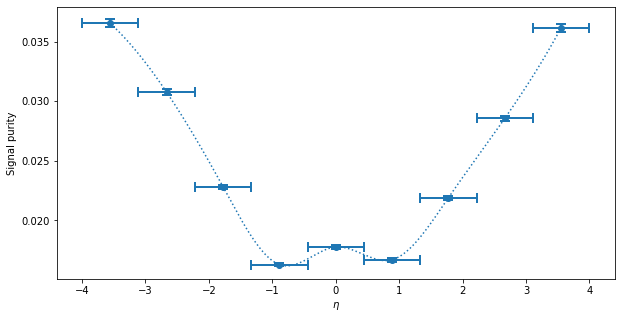

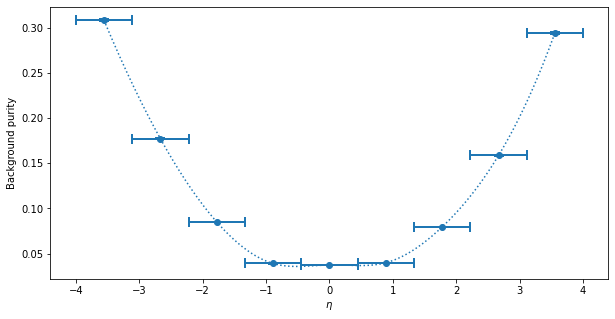

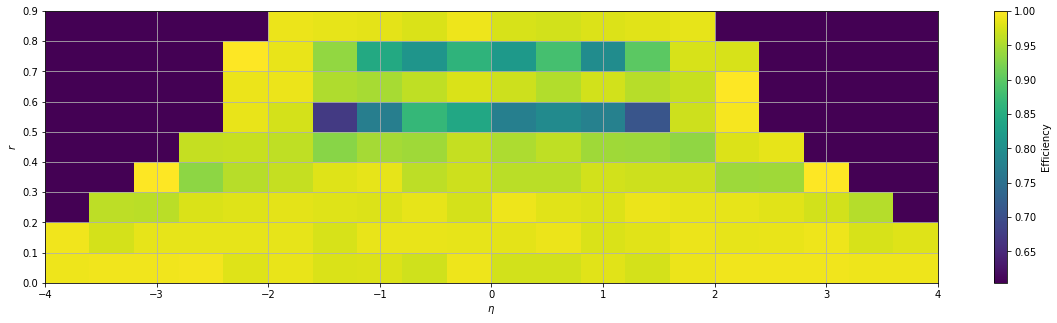

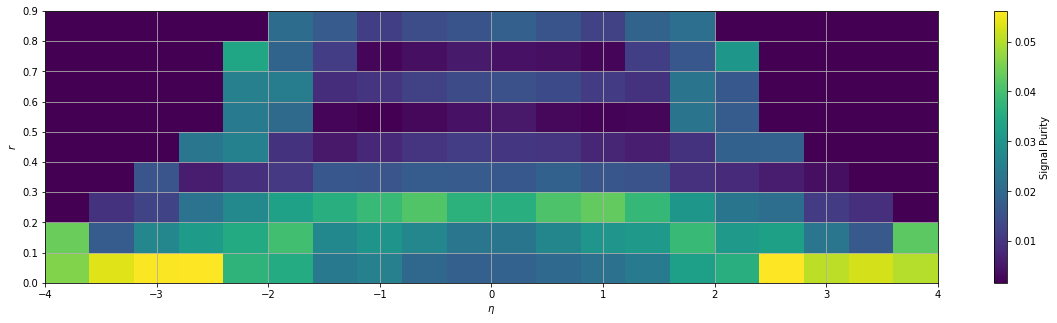

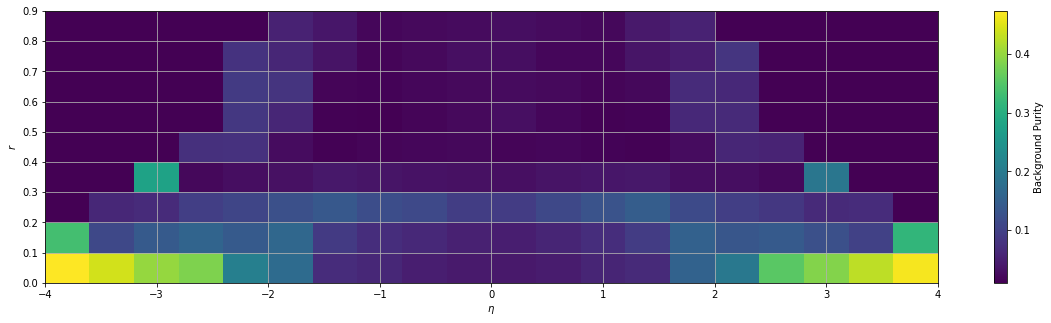

In [5]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_Filter/c7wpdlpv/checkpoints"
single_model_figs = run_eta_performance(checkpoint_path, PyramidFilter, "val", 10, 0.15, signal_true_label="y", bkg_true_label="y_pid")

Unbalanced training with multi-model

100%|██████████| 10/10 [00:00<00:00, 67.04it/s]


Signal efficiency: tensor(0.9813) Signal purity: tensor(0.0240) Background purity: tensor(0.1791)


100%|██████████| 10/10 [00:00<00:00, 13.92it/s]


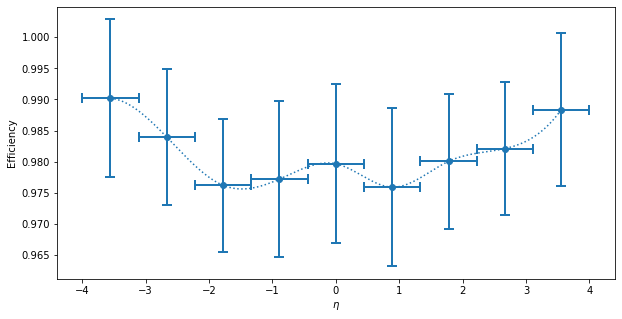

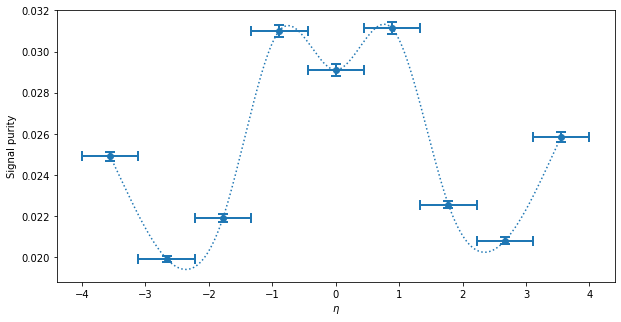

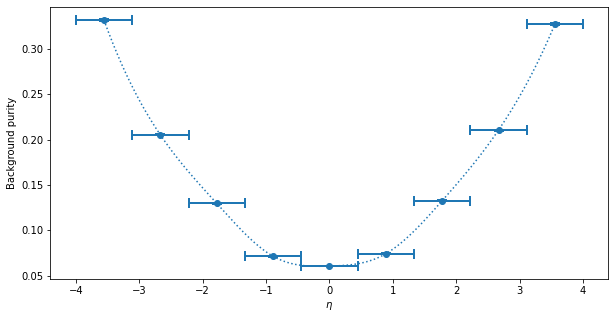

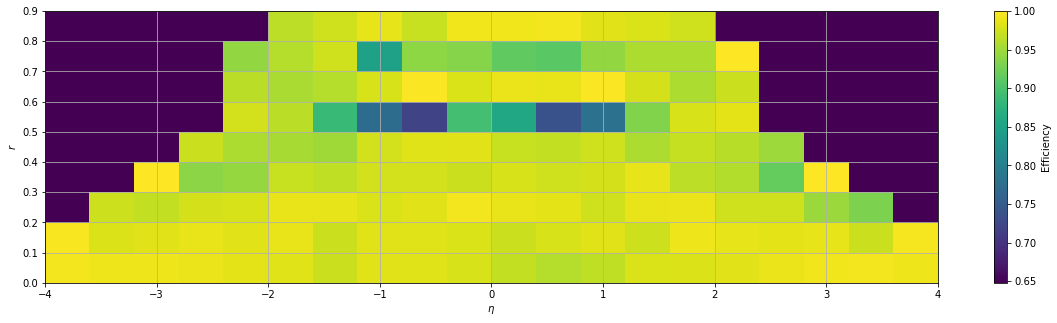

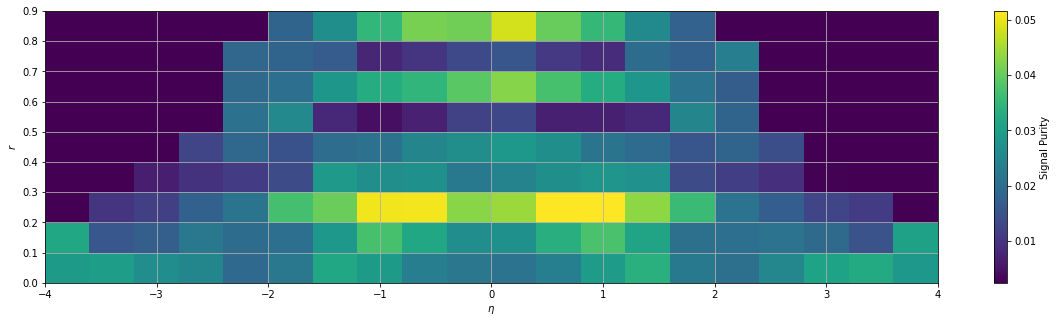

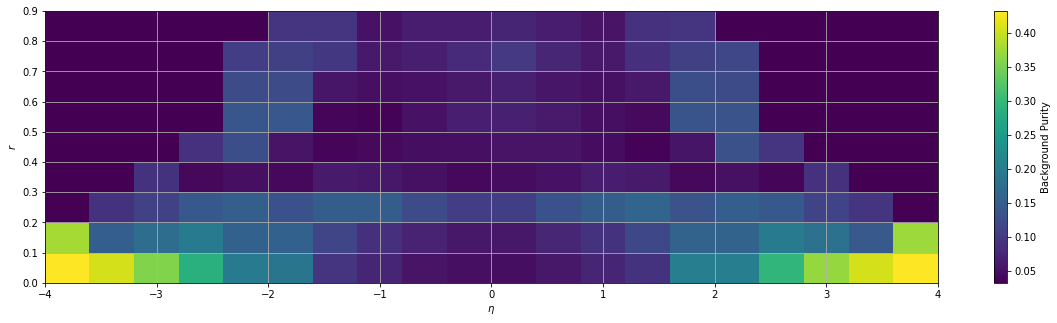

In [12]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_HeteroFilter/2kjaceyl/checkpoints/last.ckpt"
four_model_figs = run_eta_performance(checkpoint_path, HeteroPyramidFilter, "val", 10, 0.18, signal_true_label="y", bkg_true_label="y_pid")

Balanced training with multi-model

100%|██████████| 10/10 [00:00<00:00, 55.61it/s]


Signal efficiency: tensor(0.9813) Signal purity: tensor(0.0215) Background purity: tensor(0.1629)


100%|██████████| 10/10 [00:00<00:00, 11.73it/s]


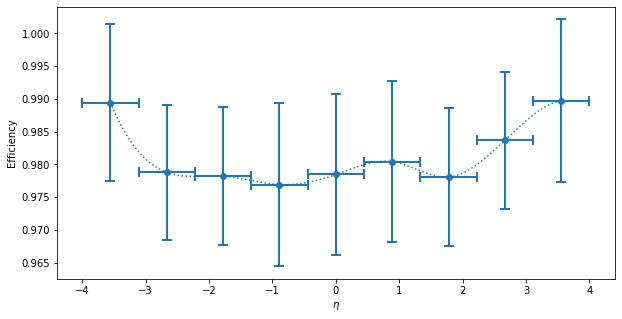

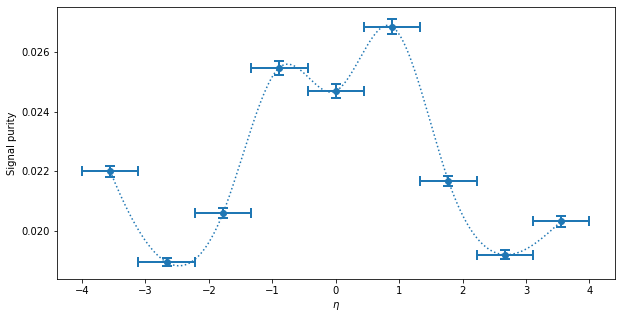

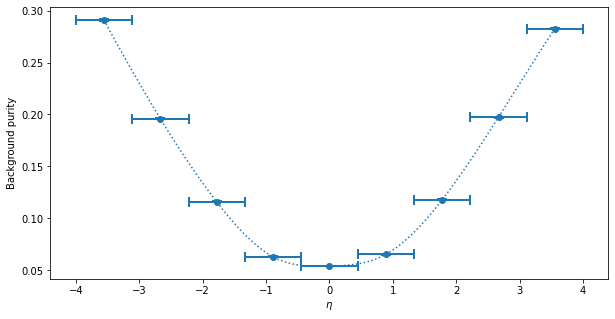

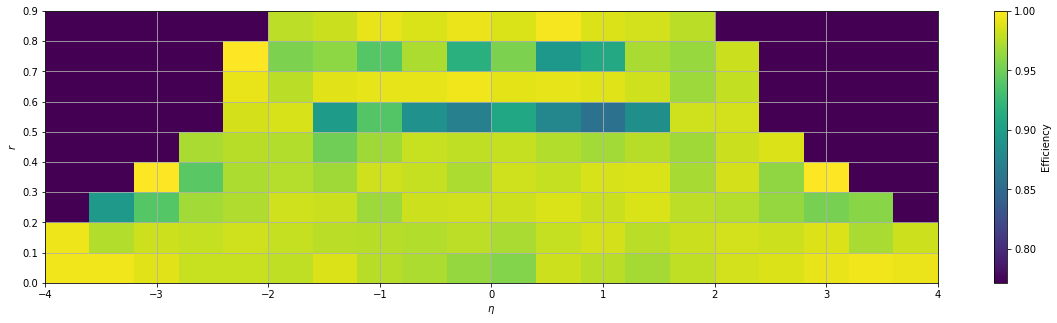

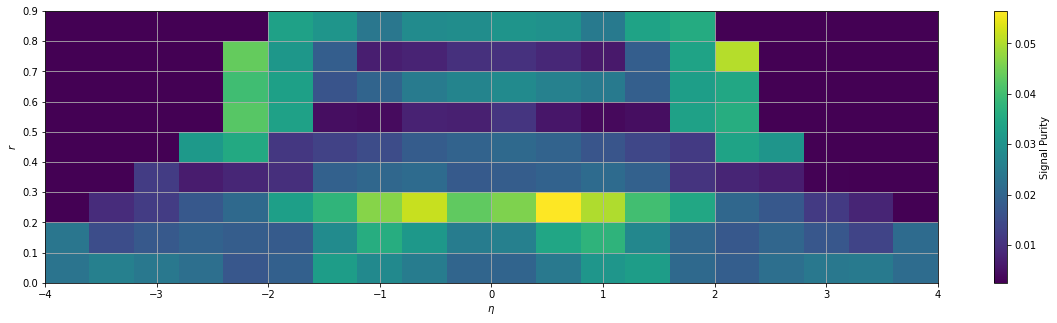

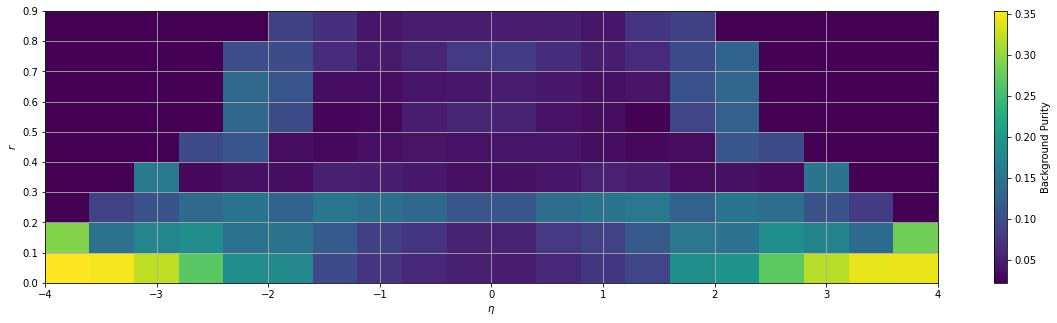

In [9]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_HeteroFilter/32nn1b7q/checkpoints/epoch=998-step=99899.ckpt"
four_model_figs = run_eta_performance(checkpoint_path, HeteroPyramidFilter, "val", 10, 0.5, signal_true_label="y", bkg_true_label="y_pid")

100%|██████████| 10/10 [00:00<00:00, 49.44it/s]


Signal efficiency: tensor(0.9929) Signal purity: tensor(0.0200) Background purity: tensor(0.1226)


100%|██████████| 10/10 [00:00<00:00, 11.36it/s]


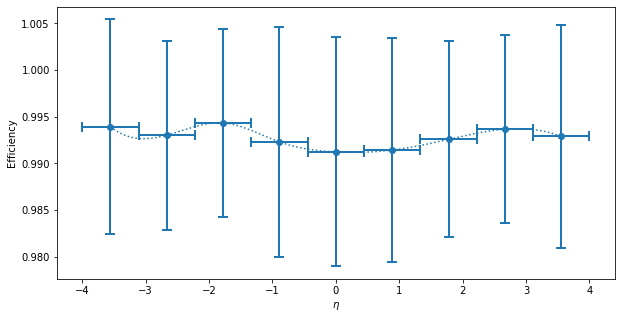

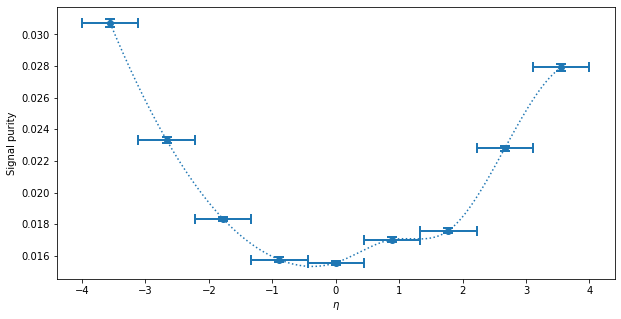

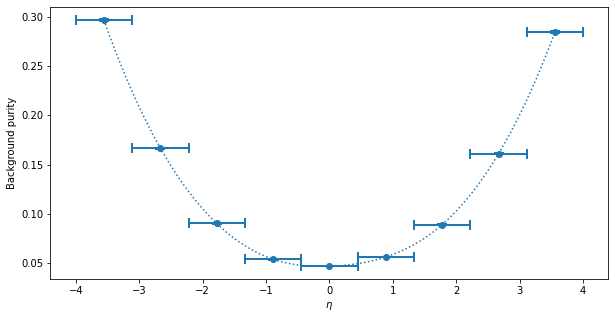

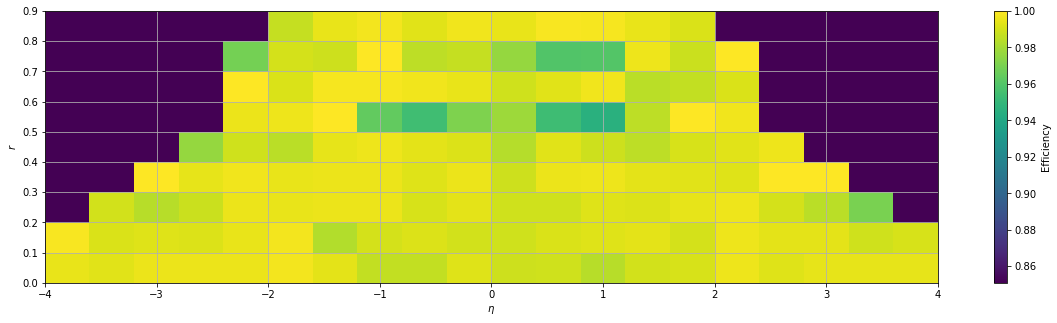

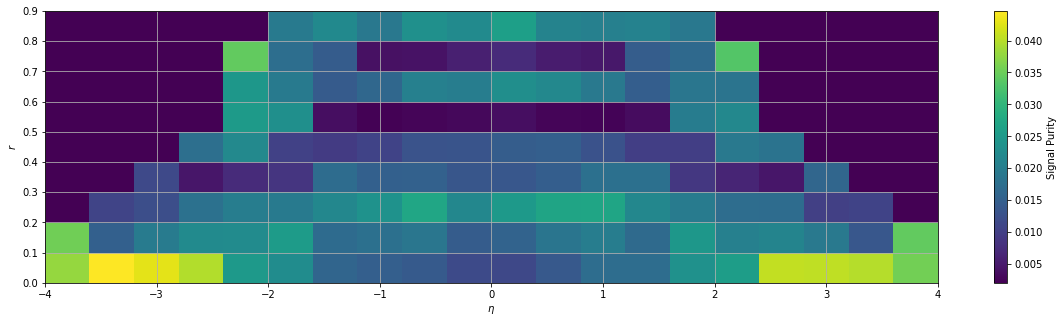

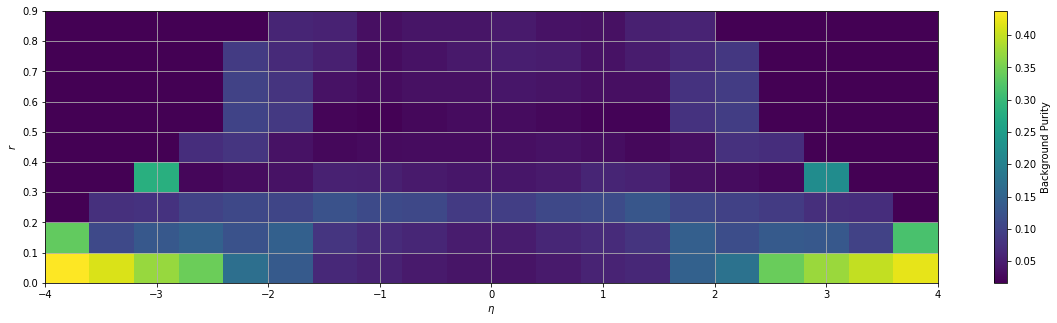

In [15]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_HeteroFilter/24rnorch/checkpoints/last.ckpt"
four_model_figs = run_eta_performance(checkpoint_path, HeteroPyramidFilter, "val", 10, 0.25, signal_true_label="y", bkg_true_label="y_pid")

100%|██████████| 100/100 [00:01<00:00, 73.99it/s]


Signal efficiency: tensor(0.9973) Signal purity: tensor(0.0147) Background purity: tensor(0.1111)


100%|██████████| 100/100 [00:03<00:00, 26.31it/s]


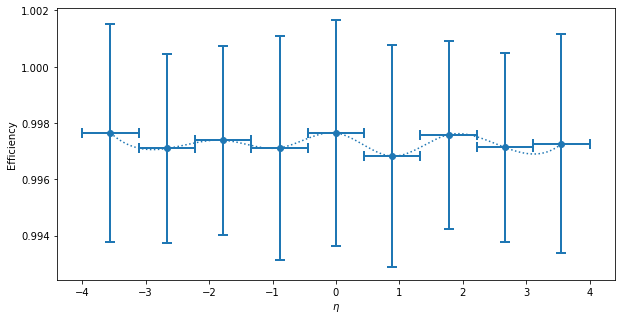

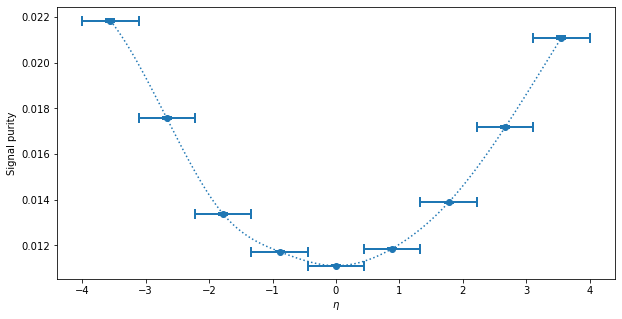

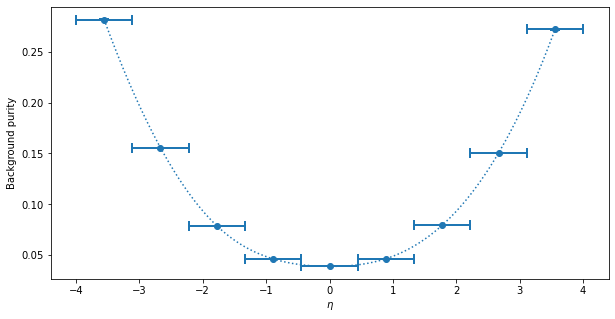

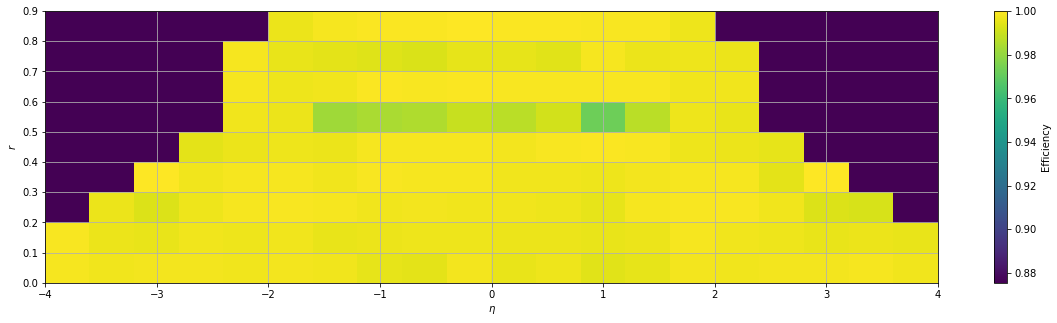

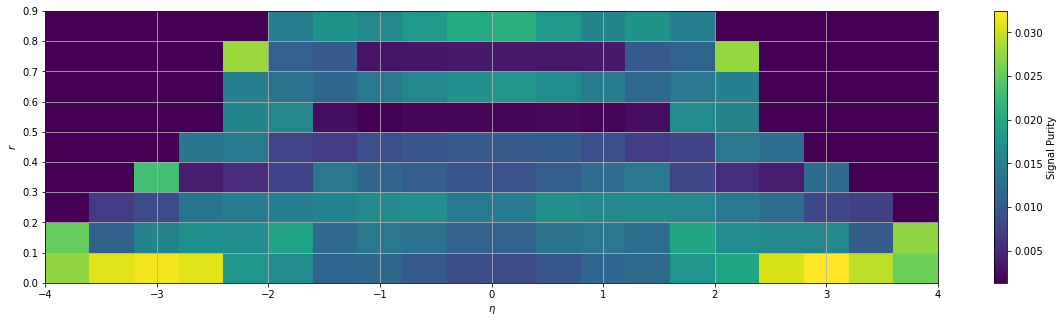

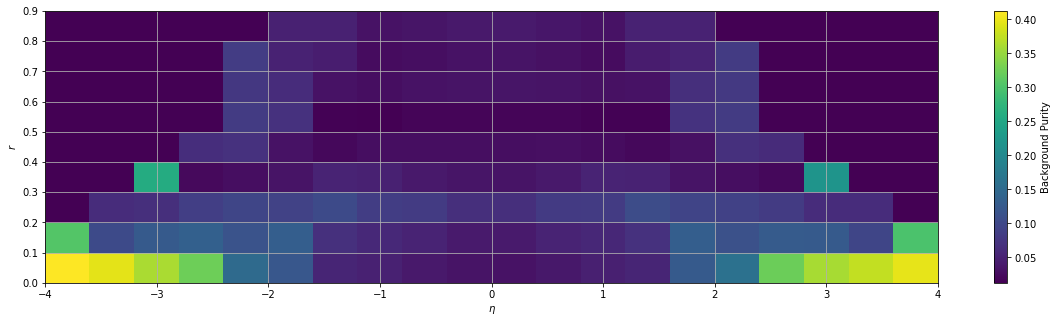

In [27]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_HeteroFilter/30j54n1r/checkpoints/epoch=1286-step=128699.ckpt"
four_model_figs = run_eta_performance(checkpoint_path, HeteroPyramidFilter, "val", 100, 0.1, signal_true_label="y", bkg_true_label="y_pid")

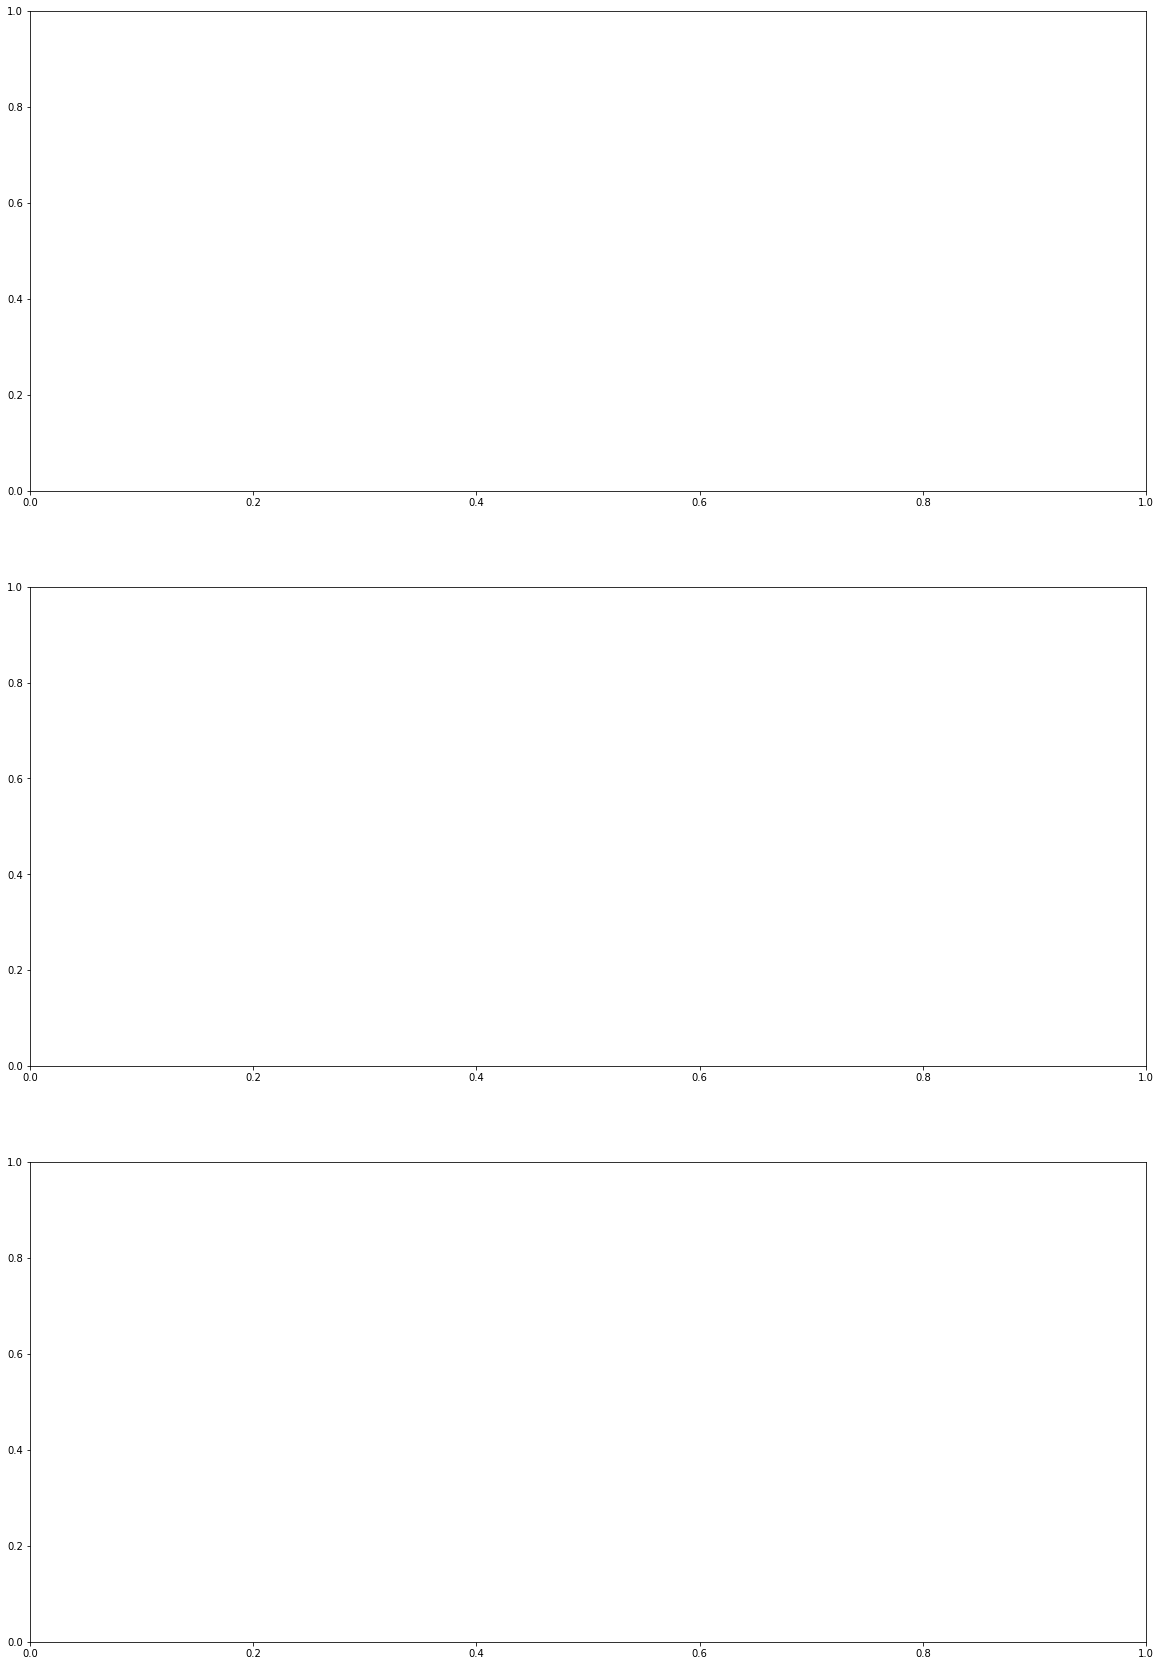

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(20, 30));

In [17]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_Filter/c7wpdlpv/checkpoints"
single_model_figs = run_eta_performance(checkpoint_path, PyramidFilter, "val", 100, 0.15, signal_true_label="y", bkg_true_label="y_pid", common_axes = axs)

100%|██████████| 100/100 [00:01<00:00, 55.63it/s]


Signal efficiency: tensor(0.9808) Signal purity: tensor(0.0220) Background purity: tensor(0.1056)


100%|██████████| 100/100 [00:04<00:00, 23.71it/s]


In [18]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_HeteroFilter/24rnorch/checkpoints/last.ckpt"
three_model_figs = run_eta_performance(checkpoint_path, HeteroPyramidFilter, "val", 100, 0.25, signal_true_label="y", bkg_true_label="y_pid", common_axes = axs)

[autoreload of gnn_utils failed: Traceback (most recent call last):
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-gpu/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-gpu/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-gpu/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-gpu/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 839, in exec_module
  File "<frozen importlib._bootstrap_external>", line 976, in get_code
  File "<frozen importlib._bootstrap_external>", line 906, in source_to_code
  File "

Signal efficiency: tensor(0.9933) Signal purity: tensor(0.0206) Background purity: tensor(0.1274)


100%|██████████| 100/100 [00:06<00:00, 15.42it/s]


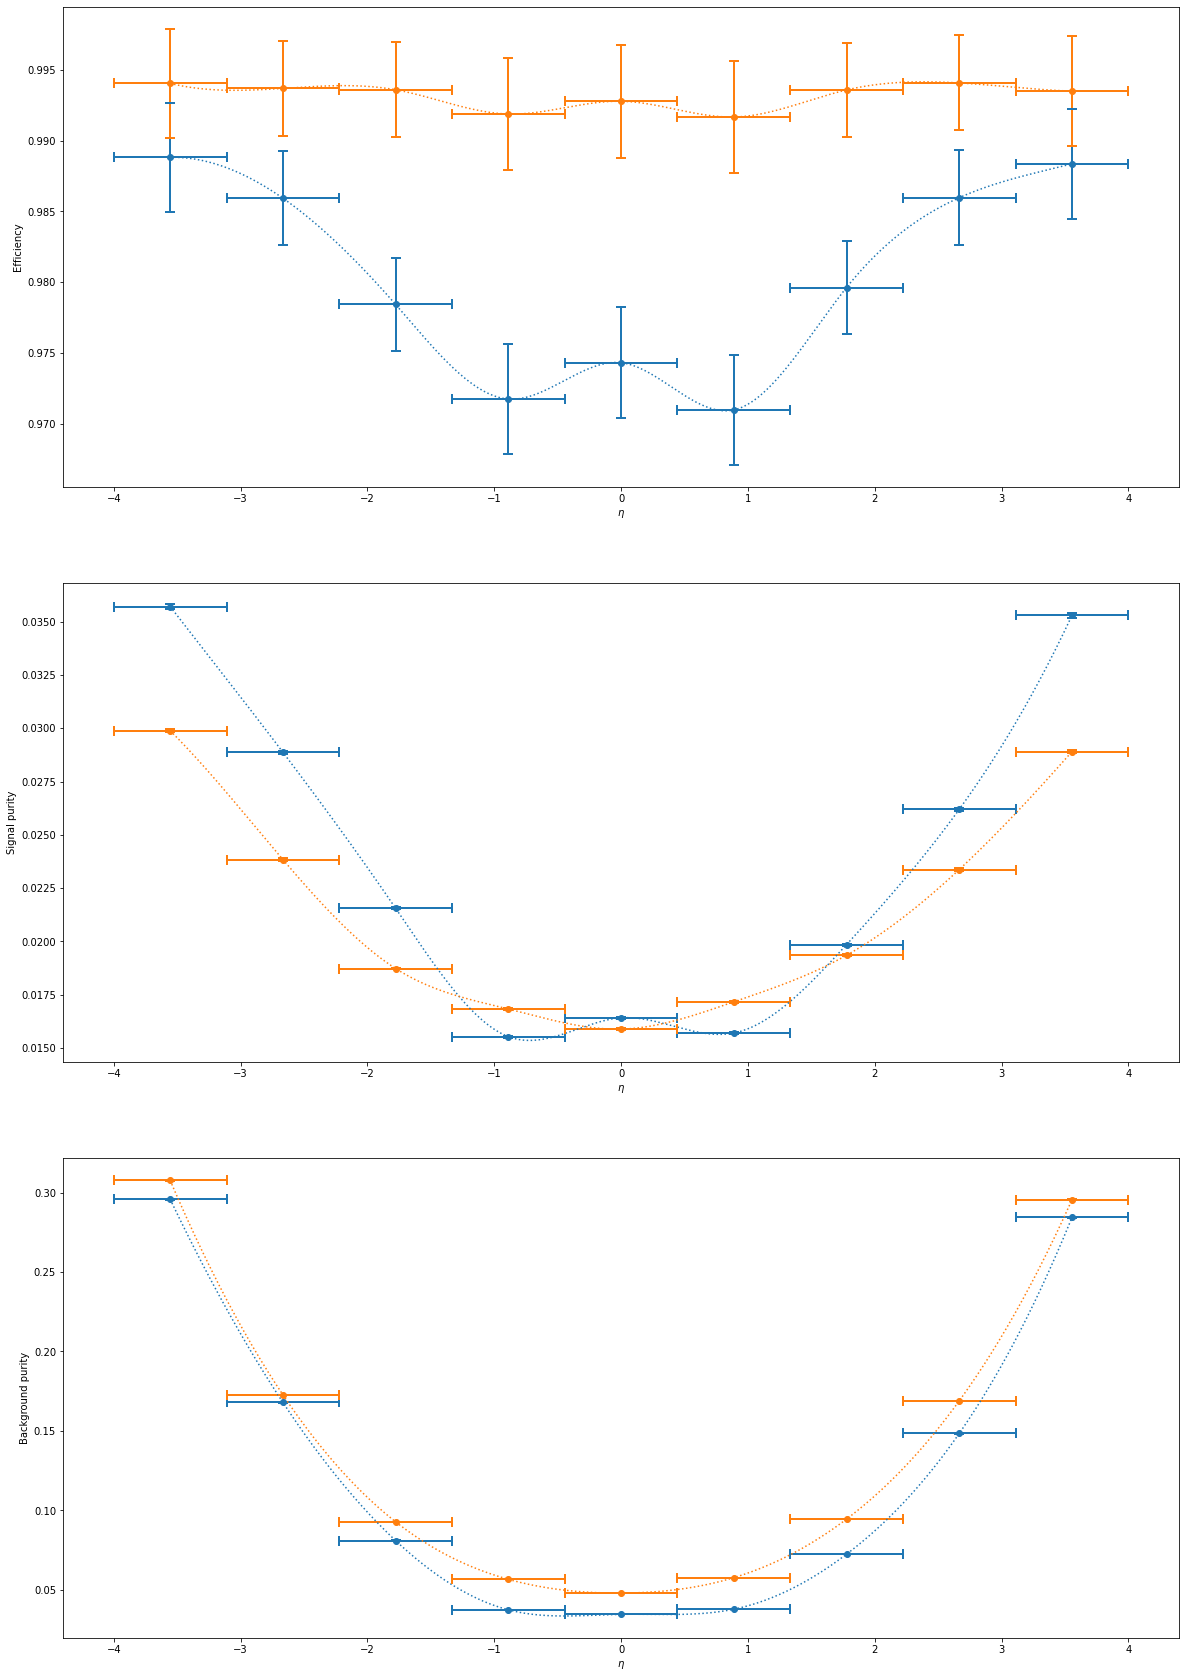

In [19]:
fig

#### pT Plots

100%|██████████| 10/10 [00:00<00:00, 58.04it/s]


Signal efficiency: tensor(0.9795) Signal purity: tensor(0.0212) Background purity: tensor(0.1036)


100%|██████████| 10/10 [00:00<00:00, 19.54it/s]


[<AxesSubplot:xlabel='$p_{T} (MeV)$', ylabel='Efficiency'>, None, None]

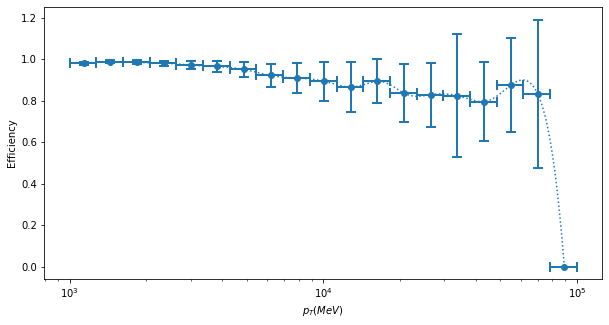

In [20]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_Filter/c7wpdlpv/checkpoints"
run_pt_performance(checkpoint_path, PyramidFilter, "val", 10, 0.15, signal_true_label="y", bkg_true_label="y_pid")

100%|██████████| 10/10 [00:00<00:00, 63.62it/s]


Signal efficiency: tensor(0.9937) Signal purity: tensor(0.0210) Background purity: tensor(0.1314)


100%|██████████| 10/10 [00:00<00:00, 22.08it/s]


[<AxesSubplot:xlabel='$p_{T} (MeV)$', ylabel='Efficiency'>, None, None]

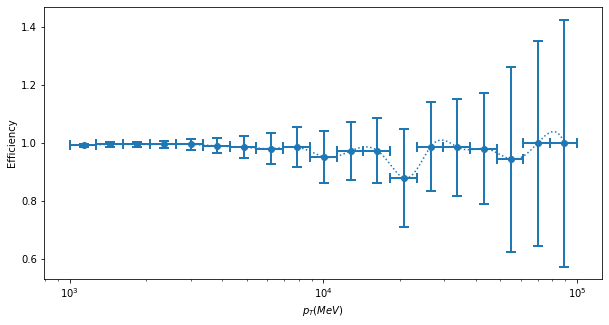

In [21]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_HeteroFilter/24rnorch/checkpoints/last.ckpt"
run_pt_performance(checkpoint_path, HeteroPyramidFilter, "val", 10, 0.25, signal_true_label="y", bkg_true_label="y_pid")

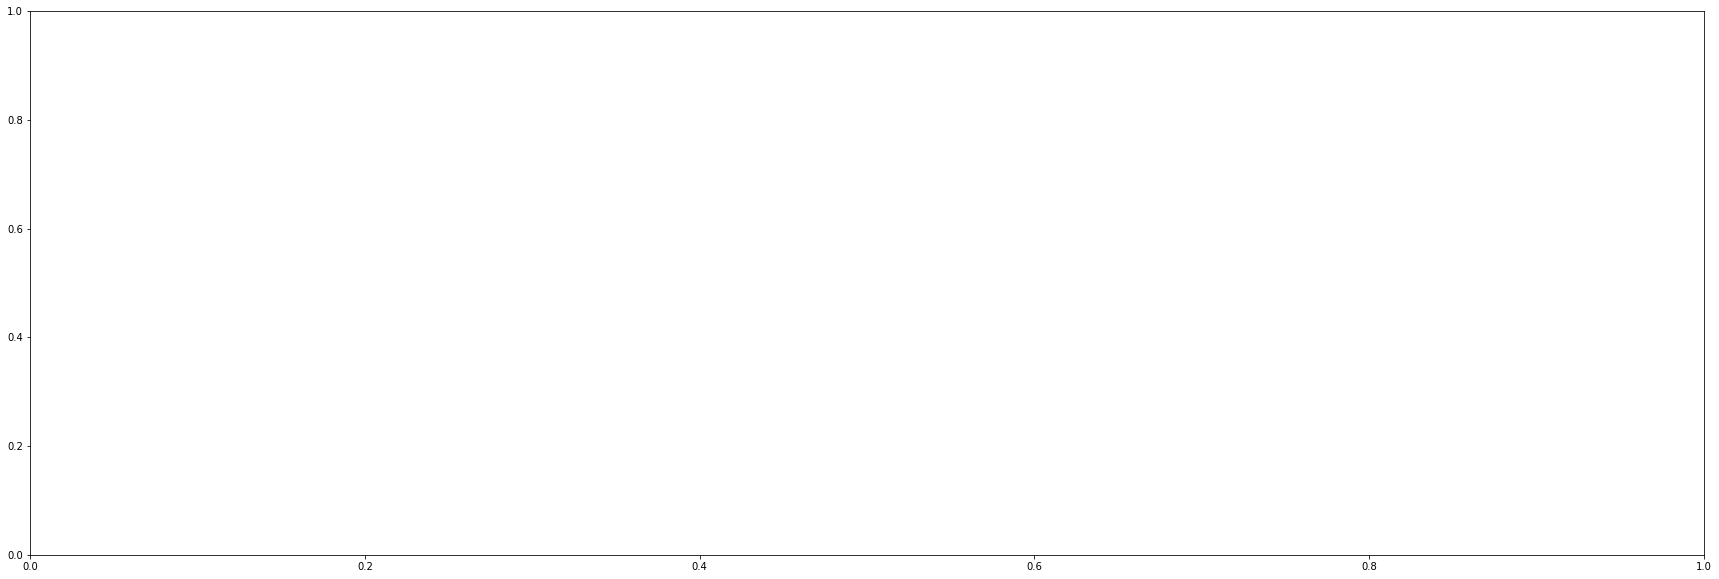

In [26]:
fig, axs = plt.subplots(1, 1, figsize=(30, 10));

In [27]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_Filter/c7wpdlpv/checkpoints"
run_pt_performance(checkpoint_path, PyramidFilter, "val", 100, 0.15, signal_true_label="y", bkg_true_label="y_pid", common_axes = axs)

100%|██████████| 100/100 [00:01<00:00, 52.28it/s]


Signal efficiency: tensor(0.9808) Signal purity: tensor(0.0220) Background purity: tensor(0.1056)


100%|██████████| 100/100 [00:03<00:00, 28.27it/s]


[<AxesSubplot:xlabel='$p_{T} (MeV)$', ylabel='Efficiency'>]

In [28]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_HeteroFilter/24rnorch/checkpoints/last.ckpt"
run_pt_performance(checkpoint_path, HeteroPyramidFilter, "val", 100, 0.25, signal_true_label="y", bkg_true_label="y_pid", common_axes = axs)

100%|██████████| 100/100 [00:01<00:00, 54.51it/s]


Signal efficiency: tensor(0.9932) Signal purity: tensor(0.0209) Background purity: tensor(0.1285)


100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


[<AxesSubplot:xlabel='$p_{T} (MeV)$', ylabel='Efficiency'>]

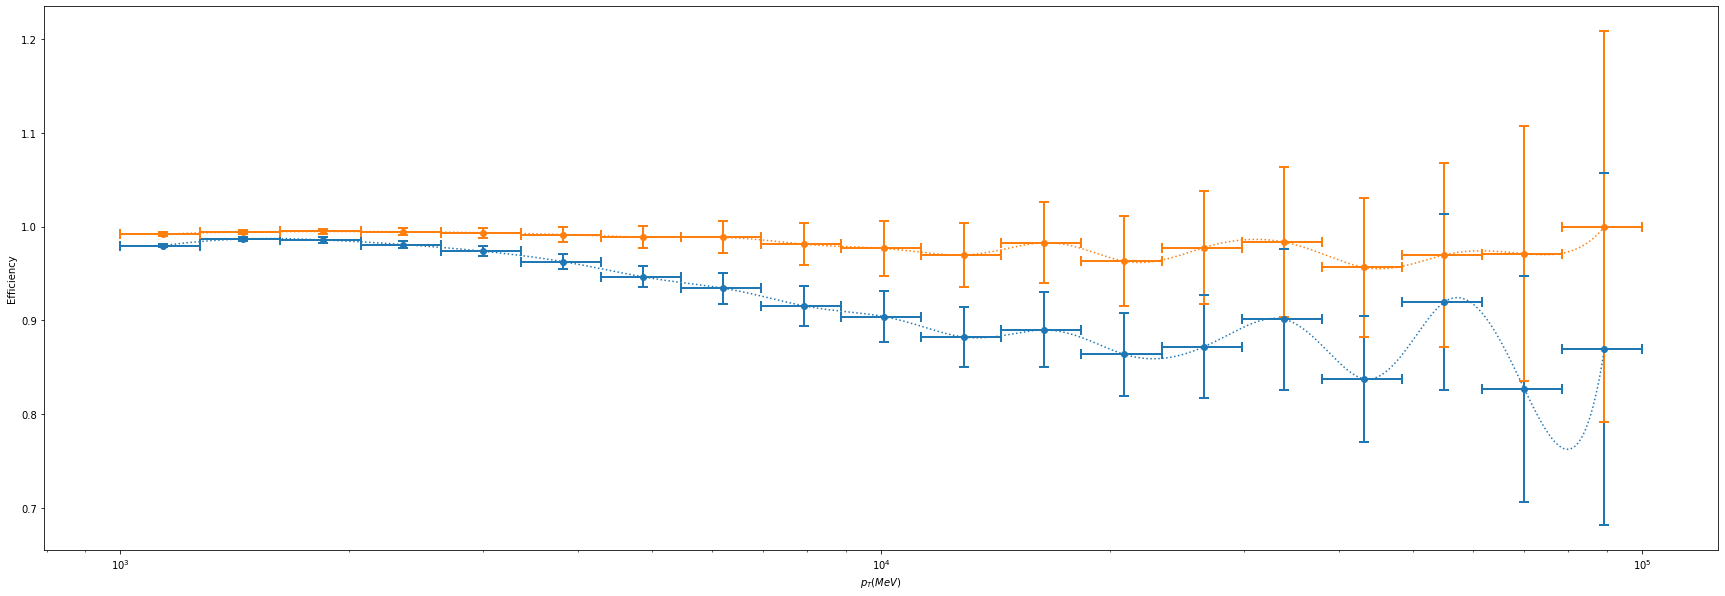

In [29]:
fig

## Total Graph Construction Performance

In [2]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_HeteroFilter/30j54n1r/checkpoints/epoch=1286-step=128699.ckpt"
checkpoint = torch.load(checkpoint_path)

model = HeteroPyramidFilter.load_from_checkpoint(checkpoint_path).to(device)

In [3]:
model.hparams["datatype_split"] = [1, 1, 200]
model.hparams["input_dir"] = "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/hetero_embedding_processed/0GeV_uncorrelated_large"
model.setup(stage="fit")

In [23]:
model = model.to(device)
cut = 0.09

f_t, a_t, p, tp = [], [], [], []

for data in tqdm(model.testset):
    data = data.to(device)
    with torch.no_grad():
        test_results = model.shared_evaluation(data, 0)
    a_t.append(data.signal_true_edges.shape[1])
    f_t.append(test_results["truth"].int().sum().cpu())
    p.append((test_results["preds"] > cut).sum().cpu())
    tp.append((test_results["truth"] & (test_results["preds"] > cut)).sum().cpu())

f_t, a_t, p, tp = np.array(f_t), np.array(a_t), np.array(p), np.array(tp)

100%|██████████| 2/2 [00:09<00:00,  4.85s/it]


In [11]:
print(f"With cut of {cut:.3f} -- Total Efficiency: {tp.sum() / a_t.sum():.4f}, Filter Efficiency: {tp.sum() / f_t.sum():.4f}, Filter Purity: {tp.sum() / p.sum():.4f}, Graph size: {int(p.mean()/1000)}k ± {int(p.std()/1000)}k")

With cut of 0.300 -- Total Efficiency: 0.9853, Filter Efficiency: 0.9885, Filter Purity: 0.0206, Graph size: 631k ± 123k


In [16]:
print(f"With cut of {cut:.3f} -- Total Efficiency: {tp.sum() / a_t.sum():.4f}, Filter Efficiency: {tp.sum() / f_t.sum():.4f}, Filter Purity: {tp.sum() / p.sum():.4f}, Graph size: {int(p.mean()/1000)}k ± {int(p.std()/1000)}k")

With cut of 0.250 -- Total Efficiency: 0.9878, Filter Efficiency: 0.9904, Filter Purity: 0.0178, Graph size: 737k ± 205k


In [18]:
print(f"With cut of {cut:.3f} -- Total Efficiency: {tp.sum() / a_t.sum():.4f}, Filter Efficiency: {tp.sum() / f_t.sum():.4f}, Filter Purity: {tp.sum() / p.sum():.4f}, Graph size: {int(p.mean()/1000)}k ± {int(p.std()/1000)}k")

With cut of 0.150 -- Total Efficiency: 0.9917, Filter Efficiency: 0.9943, Filter Purity: 0.0134, Graph size: 984k ± 275k


In [22]:
print(f"With cut of {cut:.3f} -- Total Efficiency: {tp.sum() / a_t.sum():.4f}, Filter Efficiency: {tp.sum() / f_t.sum():.4f}, Filter Purity: {tp.sum() / p.sum():.4f}, Graph size: {int(p.mean()/1000)}k ± {int(p.std()/1000)}k")

With cut of 0.100 -- Total Efficiency: 0.9937, Filter Efficiency: 0.9963, Filter Purity: 0.0111, Graph size: 1193k ± 335k


In [24]:
print(f"With cut of {cut:.3f} -- Total Efficiency: {tp.sum() / a_t.sum():.4f}, Filter Efficiency: {tp.sum() / f_t.sum():.4f}, Filter Purity: {tp.sum() / p.sum():.4f}, Graph size: {int(p.mean()/1000)}k ± {int(p.std()/1000)}k")

With cut of 0.090 -- Total Efficiency: 0.9939, Filter Efficiency: 0.9965, Filter Purity: 0.0106, Graph size: 1252k ± 352k


Then, build filtered graphs

In [29]:
from notebooks.ITk.utils import FilterInferenceBuilder

In [3]:
model.hparams["datatype_split"] = [2, 2, 200]
model.hparams["input_dir"] = "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/hetero_embedding_processed/0GeV_uncorrelated_large"
model.hparams["n_chunks"] = 8
output_dir = "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/hetero_filter_processed/0GeV_uncorrelated_large"

model.setup(stage="fit")

In [4]:
model.testset

LargeDataset(200)

In [39]:
edge_builder = FilterInferenceBuilder(model, output_dir, hetero=True, overwrite=False)

edge_builder.build()

Training finished, running inference to build graphs...


3it [00:04,  1.36s/it]
3it [00:03,  1.29s/it]
45it [01:11,  1.60s/it]


RuntimeError: CUDA out of memory. Tried to allocate 14.62 GiB (GPU 0; 39.59 GiB total capacity; 17.09 GiB already allocated; 12.95 GiB free; 22.59 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
def save_downstream(self, batch, datatype):

    with open(
        os.path.join(self.output_dir, datatype, batch.event_file[-4:]), "wb"
    ) as pickle_file:
        torch.save(batch, pickle_file)

In [4]:
model = model.to(device)
cut = 0.1

model.eval()
for data in tqdm(model.test_dataloader()):
    if not os.path.exists(os.path.join(output_dir, "test", data[0].event_file[-4:])):
        data = data[0].to(device)
        with torch.no_grad():
            test_results = model.shared_evaluation(data, 0)
        edge_cut = test_results["preds"] > cut
        data.edge_index = data.edge_index[:, edge_cut]
        data.y = data.y[edge_cut]
        data.y_pid = data.y_pid[edge_cut]

        print(torch.cuda.max_memory_allocated() // 1024 **3)

        with open(
            os.path.join(output_dir, "test", data.event_file[-4:]), "wb"
        ) as pickle_file:
            torch.save(data, pickle_file)

  1%|          | 2/200 [00:06<12:36,  3.82s/it]

8


  4%|▍         | 9/200 [00:18<09:07,  2.87s/it]

9


  6%|▌         | 11/200 [00:20<06:02,  1.92s/it]

10


  8%|▊         | 16/200 [00:35<09:12,  3.00s/it]

10


  9%|▉         | 18/200 [00:41<10:10,  3.35s/it]

10


 10%|█         | 21/200 [00:52<12:02,  4.04s/it]

13


 11%|█         | 22/200 [00:58<13:33,  4.57s/it]

13


 12%|█▏        | 23/200 [01:04<15:09,  5.14s/it]

13


 14%|█▎        | 27/200 [01:11<08:15,  2.86s/it]

13


 14%|█▍        | 29/200 [01:16<07:44,  2.71s/it]

13


 16%|█▌        | 31/200 [01:23<09:53,  3.51s/it]

13


 26%|██▌       | 51/200 [01:51<06:54,  2.78s/it]

13


 26%|██▌       | 52/200 [01:56<08:46,  3.56s/it]

13


 28%|██▊       | 56/200 [02:04<06:14,  2.60s/it]

13


 28%|██▊       | 57/200 [02:11<09:41,  4.07s/it]

13


 32%|███▏      | 63/200 [02:22<05:52,  2.58s/it]

13


 32%|███▎      | 65/200 [02:30<08:28,  3.76s/it]

13


 34%|███▍      | 68/200 [02:39<07:47,  3.54s/it]

13


 34%|███▍      | 69/200 [02:44<08:39,  3.96s/it]

13


 37%|███▋      | 74/200 [02:54<06:15,  2.98s/it]

13


 41%|████      | 82/200 [03:07<04:41,  2.39s/it]

13


 42%|████▏     | 84/200 [03:15<06:48,  3.52s/it]

13


 44%|████▎     | 87/200 [03:26<07:22,  3.92s/it]

13


 45%|████▌     | 90/200 [03:35<07:11,  3.93s/it]

13


 46%|████▌     | 92/200 [03:41<06:16,  3.49s/it]

13


 49%|████▉     | 98/200 [03:52<04:57,  2.92s/it]

13


 51%|█████     | 102/200 [04:01<04:22,  2.68s/it]

13


 55%|█████▍    | 109/200 [04:14<04:36,  3.04s/it]

13


 56%|█████▌    | 112/200 [04:21<04:36,  3.14s/it]

13


 57%|█████▊    | 115/200 [04:30<04:46,  3.37s/it]

13


 66%|██████▌   | 132/200 [04:55<03:12,  2.83s/it]

13


 67%|██████▋   | 134/200 [05:01<03:15,  2.96s/it]

13


 69%|██████▉   | 138/200 [05:05<01:31,  1.48s/it]

13


 71%|███████   | 142/200 [05:21<03:17,  3.41s/it]

13


 76%|███████▌  | 152/200 [05:39<02:22,  2.97s/it]

13


 76%|███████▋  | 153/200 [05:44<02:43,  3.47s/it]

13


 77%|███████▋  | 154/200 [05:50<03:13,  4.21s/it]

13


 78%|███████▊  | 157/200 [05:59<02:59,  4.17s/it]

13


 80%|████████  | 160/200 [06:07<02:13,  3.34s/it]

13


 82%|████████▎ | 165/200 [06:16<01:29,  2.55s/it]

13


 83%|████████▎ | 166/200 [06:22<02:02,  3.60s/it]

13


 84%|████████▎ | 167/200 [06:28<02:23,  4.34s/it]

13


 84%|████████▍ | 168/200 [06:32<02:19,  4.36s/it]

13


 86%|████████▌ | 171/200 [06:40<01:42,  3.54s/it]

13


 87%|████████▋ | 174/200 [06:50<01:46,  4.08s/it]

14


 88%|████████▊ | 176/200 [06:53<01:06,  2.76s/it]

14


 92%|█████████▏| 183/200 [07:06<00:38,  2.26s/it]

14


 92%|█████████▏| 184/200 [07:12<00:51,  3.25s/it]

14


 92%|█████████▎| 185/200 [07:16<00:53,  3.58s/it]

14


 93%|█████████▎| 186/200 [07:22<00:58,  4.20s/it]

14


 96%|█████████▌| 192/200 [07:32<00:20,  2.58s/it]

14


 96%|█████████▋| 193/200 [07:43<00:35,  5.13s/it]

16


 97%|█████████▋| 194/200 [07:50<00:34,  5.73s/it]

16


 98%|█████████▊| 197/200 [08:00<00:13,  4.44s/it]

16


 99%|█████████▉| 198/200 [08:06<00:09,  4.85s/it]

16


100%|██████████| 200/200 [08:11<00:00,  2.46s/it]

16


Test performance

In [5]:
sample = torch.load("/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/hetero_filter_processed/0GeV_uncorrelated_large/test/7007")

In [6]:
sample

Data(x=[314008, 9], cell_data=[314008, 11], pid=[314008], event_file='/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/uncorrelated_events/event000007007', hid=[314008], pt=[314008], primary=[314008], nhits=[314008], modules=[314008], modulewise_true_edges=[2, 123932], signal_true_edges=[2, 13586], edge_index=[2, 1225044], y=[1225044], volume_id=[314008], y_pid=[1225044])

In [7]:
sample.y.sum() / sample.signal_true_edges.shape[1]

tensor(0.9939, device='cuda:0')

Test that efficiency of each event is high as expected:

In [9]:
input_dir = "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/hetero_filter_processed/0GeV_uncorrelated_large/test/"
files = [os.path.join(input_dir, file) for file in os.listdir(input_dir)]
for file in files:
    sample = torch.load(file)
    print(sample.y.sum() / sample.signal_true_edges.shape[1])
    if sample.y.sum() / sample.signal_true_edges.shape[1] < 0.99:
        print(file, "is below 99% !!")

tensor(0.9919, device='cuda:0')
tensor(0.9891, device='cuda:0')
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/hetero_filter_processed/0GeV_uncorrelated_large/test/5017 is below 99% !!
tensor(0.9894, device='cuda:0')
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/hetero_filter_processed/0GeV_uncorrelated_large/test/3005 is below 99% !!
tensor(0.9938, device='cuda:0')
tensor(0.9941, device='cuda:0')
tensor(0.9944, device='cuda:0')
tensor(0.9922, device='cuda:0')
tensor(0.9941, device='cuda:0')
tensor(0.9947, device='cuda:0')
tensor(0.9940, device='cuda:0')
tensor(0.9940, device='cuda:0')
tensor(0.9878, device='cuda:0')
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/hetero_filter_processed/0GeV_uncorrelated_large/test/4001 is below 99% !!
tensor(0.9941, device='cuda:0')
tensor(0.9917, device='cuda:0')
tensor(0.9881, device='cuda:0')
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/hetero_filter_processed/0GeV_uncorrelated_large/test/1009 is below 99% !!
tensor(0.9931, devic